In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load dataset (breast cancer dataset as an example)
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

In [3]:
print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Features: {feature_names}")
print(f"Classes: {target_names}")

Dataset shape: (569, 30)
Target distribution: [212 357]
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Classes: ['malignant' 'benign']


In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [6]:
# 1. Basic model with default parameters
print("\n1. INITIAL MODEL WITH DEFAULT PARAMETERS")
model = pipeline
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


1. INITIAL MODEL WITH DEFAULT PARAMETERS
Accuracy on test set: 0.9561

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        43
      benign       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [7]:
# 2. Hyperparameter tuning with GridSearchCV
print("\n2. HYPERPARAMETER TUNING")
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5],
    'classifier__subsample': [0.8, 1.0]
}

# For demonstration, we're using a smaller param_grid. In practice, you might use more values.
# You could also use RandomizedSearchCV for more efficient searching with a larger param space.

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_
best_model


2. HYPERPARAMETER TUNING
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best cross-validation score: 0.9692


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=5,
                                            n_estimators=200, random_state=42,
                                            subsample=0.8))])

In [8]:
# 3. Evaluate the optimized model
print("\n3. EVALUATING OPTIMIZED MODEL")
y_pred_best = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Accuracy on test set: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=target_names))


3. EVALUATING OPTIMIZED MODEL
Accuracy on test set: 0.9561

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        43
      benign       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



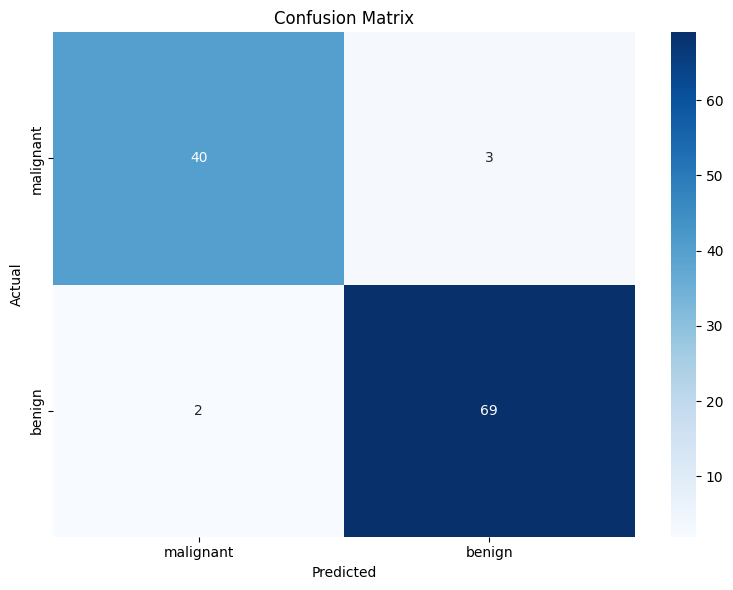

In [12]:
# 4. Visualizations
# 4.1 Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('gradient_confusion_matrix.png')
plt.show()
plt.close()

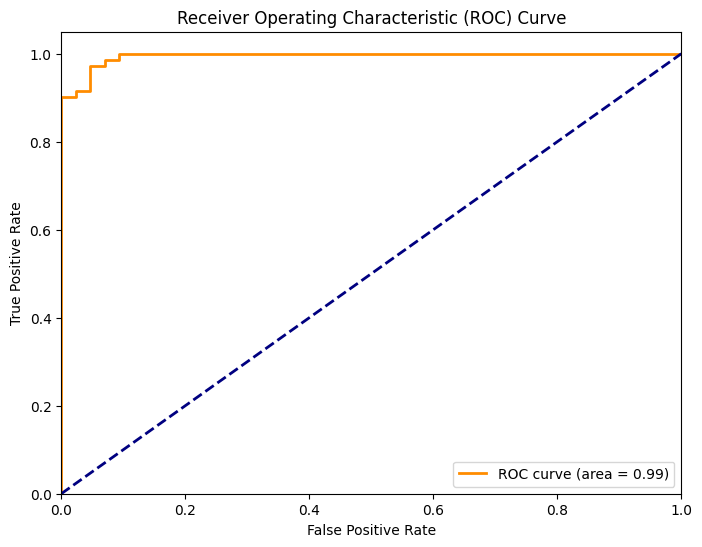

In [11]:
# 4.2 Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('gradient_roc_curve.png')
plt.show()
plt.close()

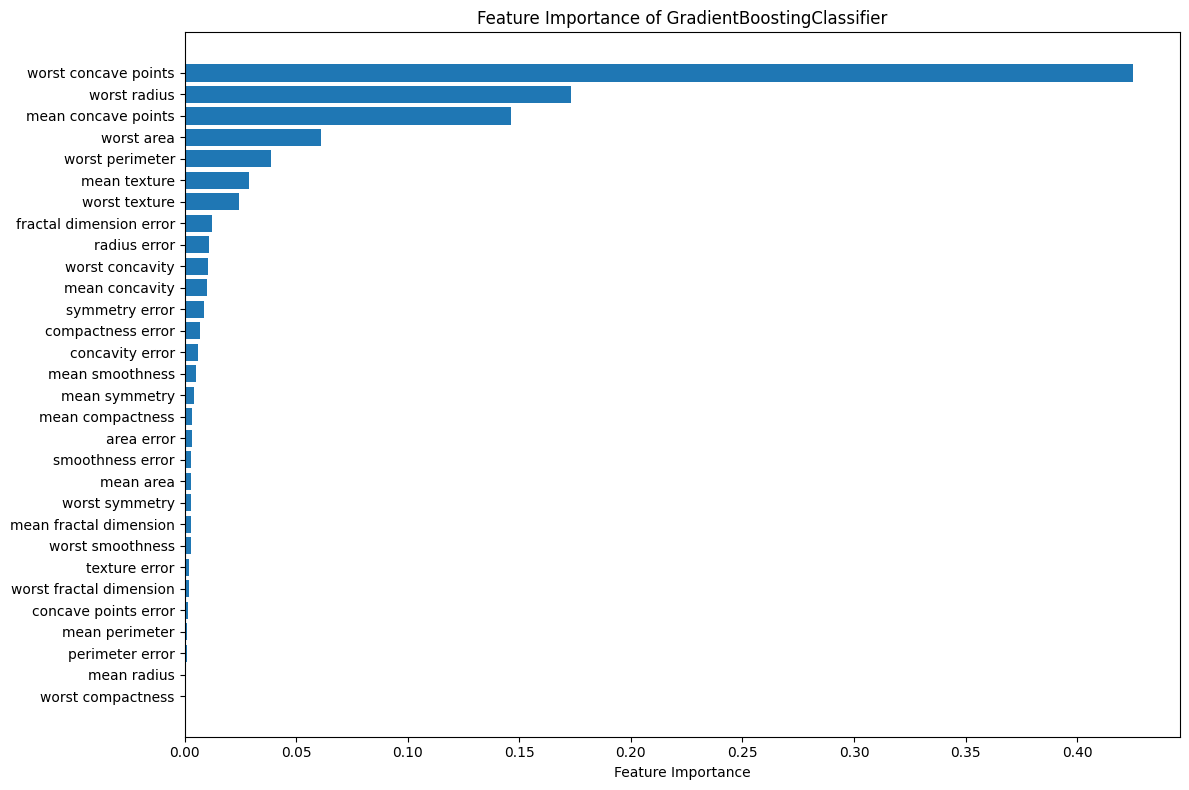

In [13]:
# 4.3 Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = best_model.named_steps['classifier'].feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance of GradientBoostingClassifier')
plt.tight_layout()
plt.savefig('gradient_feature_importance.png')
plt.show()
plt.close()

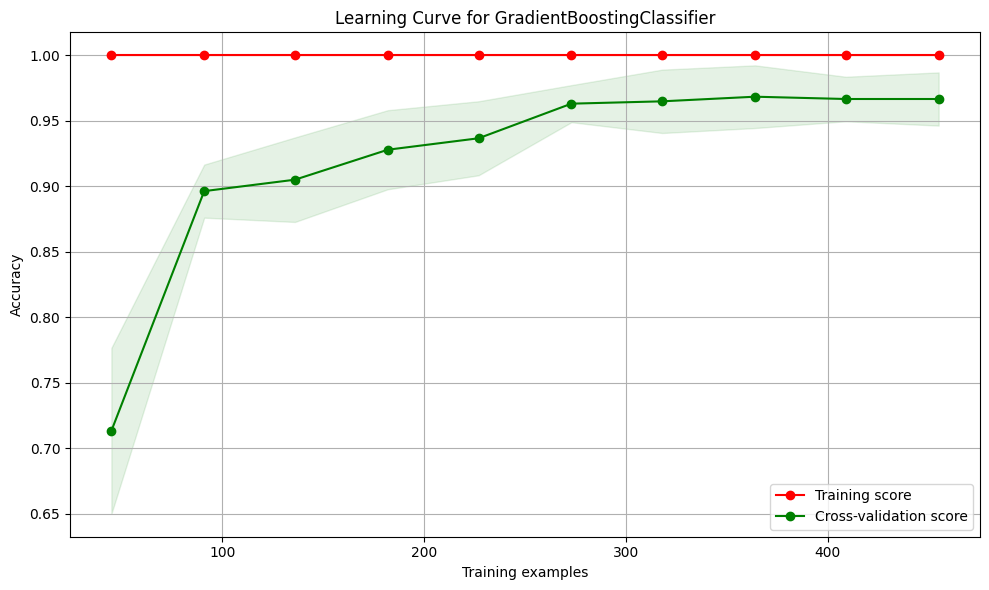

In [14]:
# 4.4 Plot learning curves to analyze bias-variance tradeoff
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5):
    plt.figure(figsize=(10, 6))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy')
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('gradient_learning_curve.png')
    plt.show()
    plt.close()

plot_learning_curve(best_model, X, y, title="Learning Curve for GradientBoostingClassifier")

In [15]:
# 5. Early stopping example
print("\n4. GRADIENT BOOSTING WITH EARLY STOPPING")

# Create validation set
X_train_es, X_val, y_train_es, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build model with early stopping
early_stopping_model = GradientBoostingClassifier(
    n_estimators=500,  # Set a large number, early stopping will determine the actual number used
    learning_rate=0.1,
    max_depth=4,
    validation_fraction=0.2,
    n_iter_no_change=10,  # Stop if no improvement after 10 iterations
    tol=1e-4,
    random_state=42,
    subsample=0.8
)

early_stopping_model.fit(X_train_es, y_train_es)

print(f"Number of estimators used (after early stopping): {early_stopping_model.n_estimators_}")
y_pred_es = early_stopping_model.predict(X_test)
print(f"Accuracy with early stopping: {accuracy_score(y_test, y_pred_es):.4f}")


4. GRADIENT BOOSTING WITH EARLY STOPPING
Number of estimators used (after early stopping): 36
Accuracy with early stopping: 0.9474


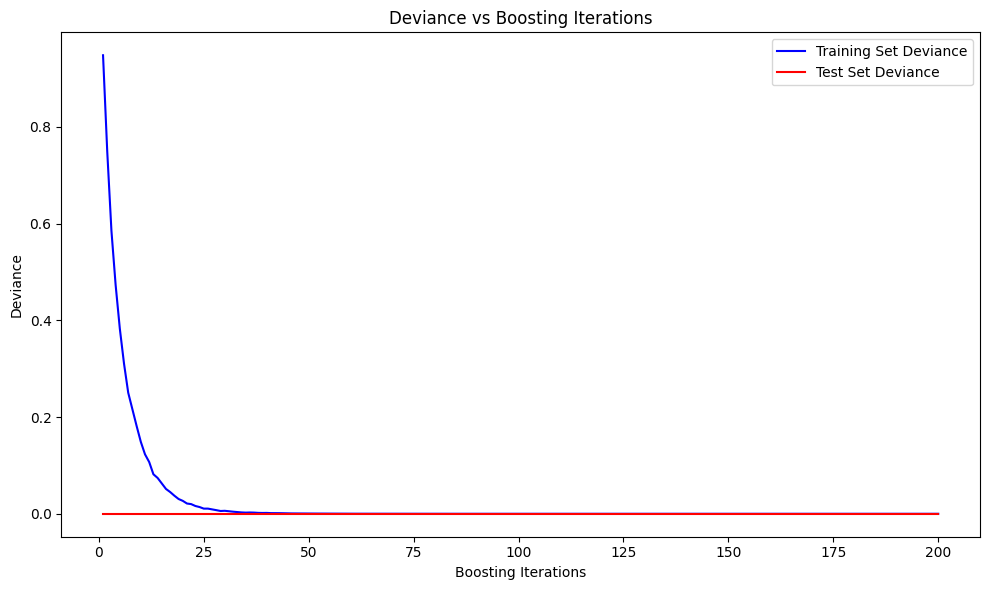


Best model saved as 'gradient_boosting_best_model.pkl'

Gradient Boosting Classifier tuning complete!


In [21]:
# 6. Track deviance (error) during training (stages)
from sklearn.metrics import log_loss

# For classification, use log loss (cross-entropy)
test_score = np.zeros((best_model.named_steps['classifier'].n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(best_model.named_steps['classifier'].staged_predict(X_test)):
    # Get the final training loss from the model
    test_score[i] = best_model.named_steps['classifier'].train_score_[-1]
    #test_score[i] = log_loss(y_test, best_model.named_steps['classifier'].predict_proba(y_pred))
    #test_score[i] = best_model.named_steps['classifier'].loss_(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(best_model.named_steps['classifier'].n_estimators) + 1, best_model.named_steps['classifier'].train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(best_model.named_steps['classifier'].n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Deviance vs Boosting Iterations')
plt.tight_layout()
plt.savefig('gradient_deviance_plot.png')
plt.show()
plt.close()

# 7. Save the best model using joblib (uncomment if needed)
import joblib
joblib.dump(best_model, 'gradient_boosting_best_model.pkl')
print("\nBest model saved as 'gradient_boosting_best_model.pkl'")

print("\nGradient Boosting Classifier tuning complete!")